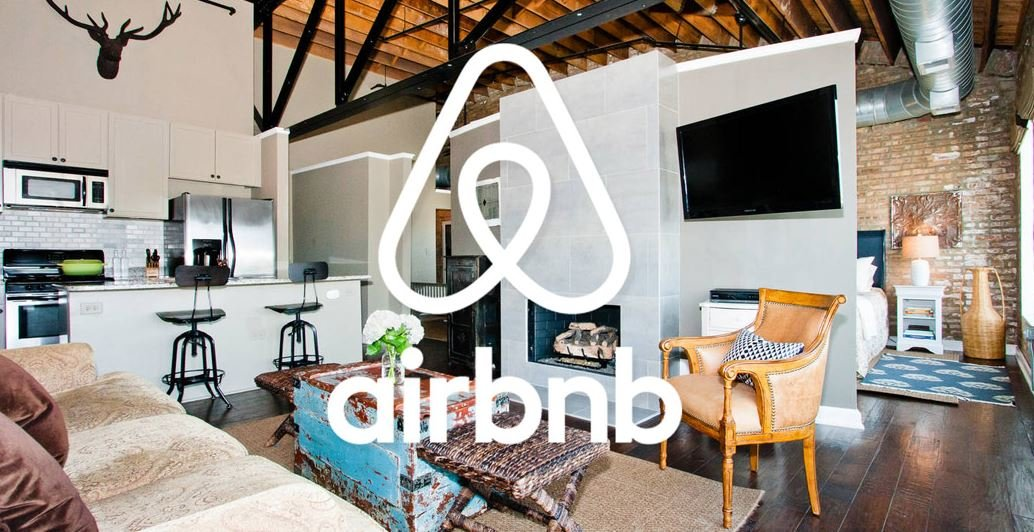

## Table of Contents

* Intro: process & technical stack
   

* 1. Scraping scripts
    * Scraping with Python
        * Scraping a list of listing ids for a set area and dates range
        * Script for scraping reviews & calendar Data
    * Docker & AWS


* 2. Processing and storing in database
    * Working locally
    * Parsing and processing JSON

# Intro <a class="anchor" id="Intro"></a>

The first step of this project is to collect and process data from Airbnb. 
The first part of this notebook presents the scripts used to scrap the data and that are dockerized and run on AWS EC2. 
The second part describes the scripts used to process and store the data in MySQL.

Data was collected in november 2021. 

## Use of the Cloud AWS

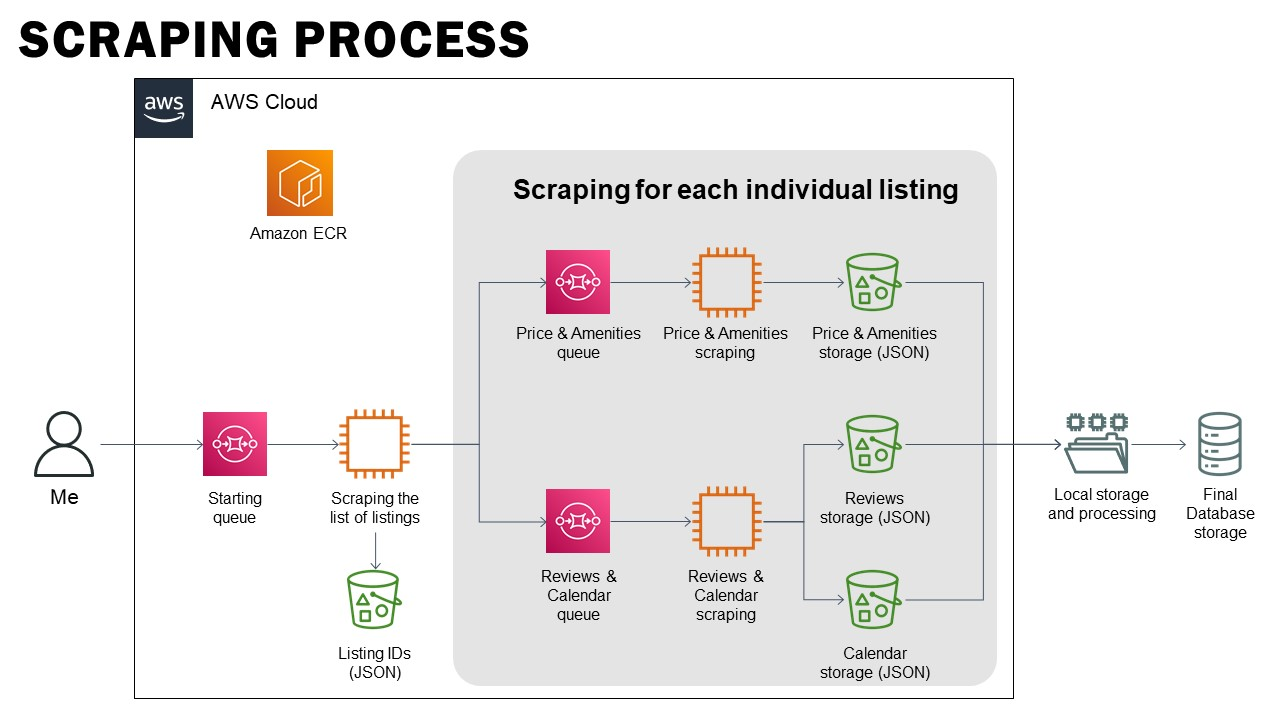

### Why EC2 instead of ECS or Lambda ? 

**Docker-compose and ECS and Lambda:** 

Ideally I would have used ECS for this project as would have allowed to spawn servers on demand and to speed up the process. 
Unfortunately I needed to operate behind a VPN to avoid being banned by Airbnb (even though the scraping rate was really slow with request every 15 seconds or more). I hence needed to use a dockerized version of the VPN but sadly docker-compose was not working on ECS at the time. 

I also found it more difficult to work behind VPN from Lambda but this solution could have cut the use of queues. 

# Scraping scripts <a class="anchor" id="scraping"></a>

### Scraping a list of listing ids for a set area and dates range <a class="anchor" id="python1"></a>

The Following script is used to collect a list of listing IDs for a specified geographical area.

The script uses the following steps:
1. Choose a target area and get its borders in terms of longitude and latitude coordinates.
2. Scan the area with smaller size increments. 
3. For each sub-sized increment collect a list of listings
4. Feed those listings to downstream queues for details scraping

In [ ]:
# ---------------------IMPORTS---------------------------------------------------------------------------
import requests
import json
import time
import random
import boto3
import logging
from math import ceil
from botocore.exceptions import ClientError

#  ---------------PARAMETRAGE----------------------------------------------------------------------------

# QUEUE LISTENING FREQUENCY
freq = 6

# SESSION A MODIFIER POUR BASCULER DU COMTPE AMAURY(DEV) A HELL(PROD)
session = boto3.Session(
    aws_access_key_id='access_key',
    aws_secret_access_key='secret_access_key'
)

# URLS DES QUEUES
QUEUES_URLS = {"starting": "URL/starting-queue.fifo",
               "IDs": "URL/ids-scraping.fifo",
               "ReviewsCalendar": "URL/RC-Q.fifo",
               "Prices": "URL/PDP-Q.fifo",
               }

#  S3 BUCKETS USED
buckets = {"listings": "abnb-listings",
           "prices": "abnb-prices",
           "reviews": "abnb-reviews",
           "calendar": "abnb-calendar"}

# COORDONNEES ET LISTE DES VILLES A SCRAPER
search_areas = {
          "Reunion": [-20.8714, 55.8403, -21.3893, 55.2086, 10],
          }

# REGION, NORMALEMENT NE BOUGE PAS 
AWS_REGION = 'eu-west-3'

# SETTING SQS CLIENT, RAF
sqs_client = session.client("sqs", region_name=AWS_REGION)

# SETTING LOGGING
logger = logging.getLogger()
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s: %(levelname)s: %(message)s')


# ---------------------SCRIPTS---------------------------------------------------------------------------

def handler(freq, buckets, QUEUES_URLS):
    FROM_QUEUE_URL = QUEUES_URLS['starting']
    on = True
    while on:
        time.sleep(freq)
        messages = receive_queue_message(FROM_QUEUE_URL)
        print(messages)
        try:
            test = messages['Messages']
        except Exception:
            print(Exception)
            logger.info("No message in the queue")
        else:
            try:
                for msg in messages['Messages']:
                    # RETRIEVING PARAMETERS FROM MESSAGE
                    msg_body = msg['Body']
                    body_json = json.loads(msg_body)
                    city = body_json['city']
                    dates_list = eval(body_json['dates_list'])
                    print(msg_body, city, dates_list)

                    # LAUNCHING SCRAPING SCRIPT
                    main_script(city, dates_list, buckets['main'], QUEUES_URLS)

                    # DELETING MESSAGE
                    receipt_handle = msg['ReceiptHandle']
                    logger.info(f'The message body: {msg_body}')
                    logger.info('Deleting message from the queue...')
                    delete_queue_message(FROM_QUEUE_URL, receipt_handle)
                    logger.info(f'Received and deleted message(s) from {FROM_QUEUE_URL}.')
            except Exception:
                print(Exception)

    return {
        'message': f'scrape reviews code executed correctly for area {city}'
    }


def compute_iter_lengths():
    """
    This function computes the width and heights increments used to scan the target area.
    Here the increments correspond to a zoom 13 on OpenStreetMap
    """
    ne_lat = 43.6386
    ne_lng = 1.5106
    sw_lat = 43.5596
    sw_lng = 1.3510
    zoom = 13
    iter_width = ne_lat - sw_lat
    iter_height = ne_lng - sw_lng

    return iter_width, iter_height


def compute_coords_settings(search_areas, city):
    """
    This function aims at preparing the paremeters used to scan the target area in the main script.
    The target area is defined as a rectangle and is scanned from bottom left corner to top right corner 
    by smaller areas of size iter_width * iter_height
    """
    iter_width, iter_height = compute_iter_lengths()

    max_ne_lat = search_areas[city][0]
    max_ne_lng = search_areas[city][1]
    min_sw_lat = search_areas[city][2]
    min_sw_lng = search_areas[city][3]

    total_width = max_ne_lat - min_sw_lat
    total_height = max_ne_lng - min_sw_lng

    width_ratio = total_width / iter_width
    height_ratio = total_height / iter_height

    num_of_width_iter = int(ceil(width_ratio))
    num_of_height_iter = int(ceil(height_ratio))

    return min_sw_lat, min_sw_lng, iter_width, iter_height, num_of_width_iter, num_of_height_iter


def main_script(city, dates_list, bucket_name, QUEUES_URLS):
    
    """
    Here we iterate our way over the target area. For each iteration area we scrap the corresponding listing ids 
    that are then passed along to waiting queues in order to scrape detail information for each id. 
    """
    
    # create the parameters used to to scan the target area
    min_sw_lat, min_sw_lng, iter_width, iter_height, num_of_width_iter, num_of_height_iter = compute_coords_settings(
        cities, city)

    # iterate over the sub areas     
    count = 0
    # listings_ids is a list used to stored all unique ids found in search results     
    listing_ids = []
    # We check several arrival and departure dates as some listings may already be booked, 
    # or require longer stays and hence not appear in the search results     
    for dates in dates_list:
        for i in range(num_of_width_iter):
            for j in range(num_of_height_iter):
                sw_lat = min_sw_lat + i * iter_width
                ne_lat = min_sw_lat + (i + 1) * iter_width
                sw_lng = min_sw_lng + j * iter_height
                ne_lng = min_sw_lng + (j + 1) * iter_height
                count = count + 1
                # current_ids is a list used to stored all unique ids found in the current scanned area and date
                current_ids = []
                continue_searching = True
                for k in range(15):
                    if continue_searching == True:
                        
                        # A random time constraint is set to very slowly ask data from Abnb 
                        # in order not to overload the server and get banned                         
                        time.sleep(random.uniform(15, 20))
                        
                        # there is amaximum of 20 listings per search page on Abnb (max 15 result pages).
                        # We use this offset variable to navigate through the result pages.                          
                        offset = k * 20
                        
                        try:
                            check_in = dates[0]
                            check_out = dates[1]
                            # The 'API' request is called to retrieve data back from Abnb's servers
                            response = scrape_map_area(check_in, check_out, sw_lat, ne_lat, sw_lng, ne_lng, offset)
                            response_text = response.text
                            print(response_text)
                            data = json.loads(response_text)
                            # Let's check if we got any data and in the right format                             
                            try:
                                items = data["data"]["dora"]["exploreV3"]["sections"][0]['items']
                            except:
                                items = data['data']['dora']["exploreV3"]['searchFooter']['sections'][0]['items']

                           # Here we do a first parse of the JSON to get back the listing IDs.
                           # If we already encountered the id then we went through all result pages 
                           # and we can go on to scan the next sub_area / date
                           # Else, we get back new data and we store it in a JSON as a security 
                           # in case detail scraping scripts fail   
                            for i, item in enumerate(items):
                                id = item['listing']['id']
                                if id in current_ids:
                                    continue_searching = False
                                    break
                                else:
                                    current_ids.append(id)
                            if continue_searching:
                                file_path = save_dataset_to_json(data,
                                                                 bucket_name,
                                                                 city,
                                                                 check_in,
                                                                 check_out,
                                                                 count,
                                                                 k)
                                print(f"JSON created at{file_path}")   

                            # If we already encountered we don't send new requests to the server  
                            for i, item in enumerate(items):
                                id = item['listing']['id']
                                print("id:", id, "i", i)
                                if id in listing_ids:
                                    pass
                                # If we encounter a new ID, we forward the relevant information to launch 
                                # the detail scraping scripts
                                else:
                                    listing_ids.append(id)
                                    capacity = item['listing']['personCapacity']
                                    feed_forward_queue("RC", "RC", city, id, check_in, check_out, "", "", QUEUES_URLS)
                                    feed_forward_queue("concealed", "concealed", city, id, check_in, check_out, "",
                                                       capacity,
                                                       QUEUES_URLS)

                        except Exception:
                            print(Exception)
                    else:
                        break
    return


def scrape_map_area(check_in_date, check_out_date, sw_lat, ne_lat, sw_lng, ne_lng, offset):
     
    """
    script to request data from Abnb's server. Built with postman and parametrize for iterations variables. 
    """
    
    
    url = f"https://www.airbnb.fr/api/v3/ExploreSearch?operationName=ExploreSearch&locale=fr&currency=EUR&variables=%7B%22request%22%3A%7B%22metadataOnly%22%3Afalse%2C%22version%22%3A%221.8.2%22%2C%22itemsPerGrid%22%3A20%2C%22tabId%22%3A%22home_tab%22%2C%22refinementPaths%22%3A%5B%22%2Fhomes%22%5D%2C%22flexibleTripDates%22%3A%5B%22november%22%2C%22october%22%5D%2C%22flexibleTripLengths%22%3A%5B%22weekend_trip%22%5D%2C%22datePickerType%22%3A%22calendar%22%2C%22checkin%22%3A%22{check_in_date}%22%2C%22checkout%22%3A%22{check_out_date}%22%2C%22adults%22%3A1%2C%22source%22%3A%22structured_search_input_header%22%2C%22searchType%22%3A%22user_map_move%22%2C%22neLat%22%3A%22{ne_lat}%22%2C%22neLng%22%3A%22{ne_lng}%22%2C%22swLat%22%3A%22{sw_lat}%22%2C%22swLng%22%3A%22{sw_lng}%22%2C%22searchByMap%22%3Atrue%2C%22placeId%22%3A%22ChIJMySoO04FU4cRniPNrMWMPKg%22%2C%22federatedSearchSessionId%22%3A%22740ec27a-6b30-4b7e-97e2-cd74bd89134f%22%2C%22itemsOffset%22%3A{offset}%2C%22sectionOffset%22%3A3%2C%22query%22%3A%22Le%20Mans%22%2C%22cdnCacheSafe%22%3Afalse%2C%22treatmentFlags%22%3A%5B%22flex_destinations_june_2021_launch_web_treatment%22%2C%22flexible_dates_options_extend_one_three_seven_days%22%2C%22super_date_flexibility%22%2C%22search_input_placeholder_phrases%22%5D%2C%22screenSize%22%3A%22large%22%7D%7D&extensions=%7B%22persistedQuery%22%3A%7B%22version%22%3A1%2C%22sha256Hash%22%3A%22d81d0c85fc1e815c9d5718eef4398f8f3b8fb1e2c5e325989f1313fa6c3abfec%22%7D%7D&_cb=0yijg6h11pe0420yg1wm11ocv8sj"

    payload = {}
    headers = {
        'authority': 'www.airbnb.fr',
        'sec-ch-ua': '"Chromium";v="94", "Google Chrome";v="94", ";Not A Brand";v="99"',
        'x-csrf-token': 'V4$.airbnb.fr$XMi705x7GDI$NxAv8KN4mVwsa9gU8R9nJrugydYqmn_oL935U8kU=',
        'x-airbnb-api-key': 'd306zoyjsyarp7ifhu67rjxn52tv0t20',
        'x-niobe-short-circuited': 'true',
        'dpr': '1.25',
        'sec-ch-ua-platform': '"Windows"',
        'device-memory': '8',
        'x-airbnb-graphql-platform-client': 'minimalist-niobe',
        'sec-ch-ua-mobile': '?0',
        'x-csrf-without-token': '1',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.61 Safari/537.36',
        'viewport-width': '955',
        'content-type': 'application/json',
        'x-airbnb-supports-airlock-v2': 'true',
        'ect': '4g',
        'x-airbnb-graphql-platform': 'web',
        'accept': '*/*',
        'sec-fetch-site': 'same-origin',
        'sec-fetch-mode': 'cors',
        'sec-fetch-dest': 'empty',
        'referer': f'https://www.airbnb.fr/Reunion/homes?tab_id=home_tab&refinement_paths%5B%5D=%2Fhomes&flexible_trip_dates%5B%5D=november&flexible_trip_dates%5B%5D=october&flexible_trip_lengths%5B%5D=weekend_trip&date_picker_type=calendar&checkin={check_in_date}&checkout={check_out_date}&adults=1&source=structured_search_input_header&search_type=user_map_move&ne_lat={ne_lat}&ne_lng={ne_lng}&sw_lat={sw_lat}&sw_lng={sw_lng}&zoom=15&search_by_map=true&place_id=ChIJMySoO04FU4cRniPNrMWMPKg&federated_search_session_id=740ec27a-6b30-4b7e-97e2-cd74bd89134f&pagination_search=true&items_offset={offset}&section_offset=3',
        'accept-language': 'fr-FR,fr;q=0.9',
        'cookie': 'Session_Cookie'  }

    response = requests.request("GET", url, headers=headers, data=payload)

    return response


def send_queue_message(queue_url, msg_attributes, msg_body):
    """
    Sends a message to the specified queue.
    """
    try:
        response = sqs_client.send_message(QueueUrl=queue_url,
                                           MessageAttributes=msg_attributes,
                                           MessageBody=msg_body,
                                           MessageGroupId=str(random.randint(0, 1000)))
    except ClientError:
        logger.exception(f'Could not send meessage to the - {queue_url}.')
        raise
    else:
        return response


def save_dataset_to_json(dataset, bucketname, city, check_in, check_out, count, k):
    """
    function that saves a dataset to a JSON file in the targeted AWS Bucket
    """

    file_name = f'RAW_JSON/main/{city}_{check_in}_{check_out}_iter_{count}_page{k + 1}.json'

    s3 = session.resource('s3', region_name=AWS_REGION)

    s3object = s3.Object(bucketname, file_name)

    s3object.put(
        Body=(bytes(json.dumps(dataset).encode('UTF-8')))
    )

    return file_name


def receive_queue_message(queue_url):
    """
    Retrieves one or more messages (up to 10), from the specified queue.
    """
    try:
        response = sqs_client.receive_message(QueueUrl=queue_url)
    except ClientError:
        logger.exception(
            f'Could not receive the message from the - {queue_url}.')
        raise
    else:
        return response


def delete_queue_message(queue_url, receipt_handle):
    """
    Deletes the specified message from the specified queue.
    """
    try:
        response = sqs_client.delete_message(QueueUrl=queue_url,
                                             ReceiptHandle=receipt_handle)
    except ClientError:
        logger.exception(
            f'Could not delete the meessage from the - {queue_url}.')
        raise
    else:
        return response

def feed_forward_queue(queue, cat, city, listing_id, check_in, check_out, file_path, capacity, QUEUES_URLS):
    
    """
    Feeds downstream queues with the parameters needed to scrape detailed data about unique listing IDs
    """
    MSG_ATTRIBUTES = {
        'Title': {
            'DataType': 'String',
            'StringValue': 'my_scraping_project'
        },
        'Author': {
            'DataType': 'String',
            'StringValue': 'scrapingmain'
        }
    }

    MSG_BODY = '{' + f'"cat":"{cat}", "city":"{city}","capacity":"{capacity}","file_path":"{file_path}","listing_id":"{listing_id}","check_in":"{check_in}",' \
                     f'"check_out":"{check_out}"' + "}"

    msg = send_queue_message(QUEUES_URLS[queue], MSG_ATTRIBUTES, MSG_BODY)
    json_msg = json.dumps(msg, indent=4)

    logger.info(f'''
        Message sent to the queue {QUEUES_URLS[cat]}.
        Message attributes: \n{json_msg}''')

    return


#  ----------------MAIN----------------------------------------------------------------------
if __name__ == "__main__":
    handler(freq, buckets, QUEUES_URLS)


### What I could have done better

I chose at first to keep all functions in one script as it was easier to dockerize. But I probably should have separated functions used to interact with AWS products to make the code more readable and reusable. 
Also I could have parametrized area variables in a more efficient way. 

# Script for scraping reviews & calendar Data <a class="anchor" id="python2"></a>

Once we get a list of listing IDs on the target area and dates, we scrape detailed information for each individual listing. Below is the script used to scrape Reviews and Calendar Data. 
1. we listen for new listing ids in the Reviews & Calendar Queue

In [ ]:
docker-compose# ---------------------IMPORTS---------------------------------------------------------------------------
import requests
import json
import time
import random
import boto3
import logging
from botocore.exceptions import ClientError

#  ---------------PARAMETRAGE A VERIFIER-------------------------------------------------------------------
# QUEUE LISTENING FREQUENCY
freq=60

# SESSION A MODIFIER POUR BASCULER DU COMTPE AMAURY(DEV) A HELL(PROD)
session = boto3.Session(
    aws_access_key_id='access_key',
    aws_secret_access_key='secret_access_key'
)

# URLS DES QUEUES
QUEUES_URLS = {"starting": "URL/starting-queue.fifo",
               "IDs": "URL/ids-scraping.fifo",
               "ReviewsCalendar": "URL/RC-Q.fifo",
               "Prices": "URL/PDP-Q.fifo",
               }

#  S3 BUCKETS USED
buckets = {"listings": "abnb-listings",
           "prices": "abnb-prices",
           "reviews": "abnb-reviews",
           "calendar": "abnb-calendar"}


#  ----------------PARAMETRAGE FIXE, RIEN A MODIFIER SI TOUT VA BIEN ----------------------------------------------------------------------
# REGION, NORMALEMENT NE BOUGE PAS 
AWS_REGION = 'eu-west-3'

# SETTING SQS CLIENT, RAF
sqs_client = session.client("sqs", region_name=AWS_REGION)

# SETTING LOGGING
logger = logging.getLogger()
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s: %(levelname)s: %(message)s')


# ---------------------SCRIPTS, RIEN A MODIFIER SI TOUT VA BIEN------------------------------------------
def handler(freq,buckets,QUEUES_URLS):
    FROM_QUEUE_URL=QUEUES_URLS["RC"]
    on = True
    while on:
        time.sleep(freq)
        messages = receive_queue_message(FROM_QUEUE_URL)
        print(messages)
        try:
            test = messages['Messages']
        except Exception:
            print(Exception)
            logger.info("No message in the queue")
        else:
            try:
                for msg in messages['Messages']:
                    # RETRIEVING PARAMETERS FROM MESSAGE
                    msg_body = msg['Body']
                    body_json = json.loads(msg_body)
                    city = body_json['city']
                    check_in = body_json['check_in']
                    check_out = body_json['check_out']
                    listing_id = body_json['listing_id']
                    print(msg_body,city,check_in,check_out,listing_id)

                    # LAUNCHING REVIEWS SCRAPING SCRIPT
                    reviews_response = scrape_reviews(check_in, check_out, listing_id)
                    reviews_response_text = reviews_response.text
                    print(reviews_response_text)
                    reviews_file_path = save_dataset_to_json(reviews_response_text, buckets['reviews'], city, listing_id)
                    print('REVIEWS JSON CREATED')
                    feed_forward_queue("parsing","reviews",city,listing_id,check_in,check_out,reviews_file_path,QUEUES_URLS)

                    # LAUNCHING CALENDAR SCRAPING SCRIPT
                    calendar_response=scrape_calendar(check_in,check_out, listing_id, count=12)
                    calendar_response_text = calendar_response.text
                    print(calendar_response_text)
                    calendar_file_path = save_dataset_to_json(calendar_response_text, buckets['calendar'], city, listing_id)
                    print('REVIEWS JSON CREATED')
                    feed_forward_queue("parsing","calendar",city,listing_id,check_in,check_out,calendar_file_path,QUEUES_URLS)

                    # DELETING MESSAGE
                    receipt_handle = msg['ReceiptHandle']
                    logger.info(f'The message body: {msg_body}')
                    logger.info('Deleting message from the queue...')
                    delete_queue_message(FROM_QUEUE_URL, receipt_handle)
                    logger.info(f'Received and deleted message(s) from {FROM_QUEUE_URL}.')

            except Exception:
                print(Exception)

    return {
        'message': f'scrape reviews code executed correctly for city {city}'
    }

def feed_forward_queue(queue,cat,city,listing_id,check_in,check_out,file_path,QUEUES_URLS):
    MSG_ATTRIBUTES = {
        'Title': {
            'DataType': 'String',
            'StringValue': 'my_scraping_project'
        },
        'Author': {
            'DataType': 'String',
            'StringValue': 'scrapingmain'
        }
    }

    MSG_BODY = '{' + f'"cat":{cat}, "city":"{city}","file_path":"{file_path}","listing_id":"{listing_id}","check_in":"{check_in}",' \
                        f'"check_out":"{check_out}"' + "}"

    msg = send_queue_message(QUEUES_URLS[queue], MSG_ATTRIBUTES, MSG_BODY)
    json_msg = json.dumps(msg, indent=4)

    print(json_msg)
    logger.info(f'''
        Message sent to the queue {QUEUES_URLS[cat]}.
        Message attributes: \n{json_msg}''')

    return

def scrape_reviews(check_in, check_out, listing_id):
    t0 = time.time()
    time.sleep(random.uniform(8, 10))
    limit = 500

    url = f"https://www.airbnb.fr/api/v3/PdpReviews?operationName=PdpReviews&locale=fr&currency=EUR&variables=%7B%22request%22%3A%7B%22fieldSelector%22%3A%22for_p3%22%2C%22limit%22%3A{limit}%2C%22listingId%22%3A%22{listing_id}%22%2C%22checkinDate%22%3A%22{check_in}%22%2C%22checkoutDate%22%3A%22{check_out}%22%2C%22numberOfAdults%22%3A%221%22%2C%22numberOfChildren%22%3A%220%22%2C%22numberOfInfants%22%3A%220%22%7D%7D&extensions=%7B%22persistedQuery%22%3A%7B%22version%22%3A1%2C%22sha256Hash%22%3A%221270212fe655c436e6a746d1f75f342030d7435045e72a1da88fe6b997ef4%22%7D%7D&_cb=1n0qrfh0bng2u30caci3r04xak1w"
    payload = {}
    headers = {
        'authority': 'www.airbnb.fr',
        'sec-ch-ua': '"Chromium";v="94", "Google Chrome";v="94", ";Not A Brand";v="99"',
        'x-csrf-token': 'V4$.airbnb.fr$B6Bqvpb43Wg$-PnMm5k8TIdG82BnjGKMqFsNs6j3v_Tvb-jqc=',
        'x-airbnb-api-key': 'd306zoyjsyarp7ifhrjxn52tv0t20',
        'x-niobe-short-circuited': 'true',
        'dpr': '1.25',
        'sec-ch-ua-platform': '"Windows"',
        'device-memory': '8',
        'x-airbnb-graphql-platform-client': 'minimalist-niobe',
        'sec-ch-ua-mobile': '?0',
        'x-csrf-without-token': '1',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.61 Safari/537.36',
        'viewport-width': '954',
        'content-type': 'application/json',
        'x-airbnb-supports-airlock-v2': 'true',
        'ect': '4g',
        'x-airbnb-graphql-platform': 'web',
        'accept': '*/*',
        'sec-fetch-site': 'same-origin',
        'sec-fetch-mode': 'cors',
        'sec-fetch-dest': 'empty',
        'referer': f'https://www.airbnb.fr/rooms/{listing_id}?adults=1&check_in={check_in}&check_out={check_out}&translate_ugc=false&federated_search_id=349e1f7b-2714-4689-8ca8-0bb3fad3c103&source_impression_id=p3_1633101628_7S7qaiuvebQBLExQ&guests=1',
        'accept-language': 'fr-FR,fr;q=0.9',
        'cookie': 'bev=16331094_N4MmNlOGZkMTI3; _abck=2B762405C224F1DBB772AF653D2~-1~YAAQl/J6XKn6/997AQAADcFwPAYBb+ThYBavzgckmmJugyCiiioy6CnD0sfwl107k41GKlb6RfsSPxdGHVtJpZozgcGm+lzIVPTZcYsBsq5s3My8loouwk4oir4HQKJuzXfW6ODf8adhQzvn2utJHZFFAPidNYgY+ExD1/chIcn1Rd/Xix4xeHK1qVPZMBtWj//HTF08ui6cWdjIsLSrW59sRNcw5+8FeJGY5FRsLPzi+sPV+Zm2Igg2ZDULhupwwkTHiX3/HuY97+4e3IhaNfJS+4WnUSWOA4eN3+2yzo33aYT0zjLBlvLrvo+Nq/jDISpSf1/hrIouh9Wua2M808SVszJnN8BnA1SG/pi9gaGzQshLFEkyf5g==~-1~-1~-1; bm_sz=F71F9A4A79D51C3F03A8E2654643E73C~YAAQl/J6XKr6/997AQAADcFwPA2REbB9IBqNgLrtXWc9NkUVFgDWfoaGcErqfTO5noctsa+kYWmghUPK7juFbKPKO4TIPBeQJNbUSYJ6fTjrzlcKCTDbP+YkLqKgwX9+WZ6MYHjXmkqL3JfteOCm9EvuRYyCYZpMjWUZqdMojEFqX6/VEeWaITJKc14MuYEK/8bCgAJuFVNfc+CIhVMyDpFV9zDlJWwghu+xNJUVT6zUxdlqXc1+8q0xOkAAzWaHQIsRPpd0L6GFrLpr/PGV4CHCLY49nEzXJFIislwhGe7C7A==~3682865~3421252; jitney_client_session_id=42dd72af-fa4e-4a8e-8a4c-4ee93ff40155; jitney_client_session_created_at=1633101597; flags=0; frmfctr=wide; OptanonConsent=0_179751%3A1%2C0_183217%3A1%2C0_183345%3A1%2C0_183219%3A1%2C0_183240%3A1%2C0_179739%3A1%2C0_179743%3A1%2C0_185813%3A1%2C0_183096%3A1%2C0_179755%3A1%2C0_183215%3A1%2C0_185808%3A1%2C0_179747%3A1%2C0_179740%3A1%2C0_179744%3A1%2C0_185814%3A1%2C0_183097%3A1%2C0_179756%3A1%2C0_183216%3A1%2C0_183344%3A1%2C0_185809%3A1%2C0_179748%3A1%2C0_179752%3A1%2C0_183241%3A1%2C0_179741%3A1%2C0_183098%3A1%2C0_179745%3A1%2C0_183346%3A1%2C0_185811%3A1%2C0_179737%3A1%2C0_179757%3A1%2C0_179749%3A1%2C0_179753%3A1%2C0_185831%3A1%2C0_183099%3A1%2C0_179738%3A1%2C0_179742%3A1%2C0_183095%3A1%2C0_183243%3A1%2C0_179754%3A1%2C0_183214%3A1%2C0_179750%3A1%2C0_200000%3A1%2C0_200002%3A1%2C0_200003%3A1%2C0_200004%3A1%2C0_200005%3A1%2C0_200006%3A1%2C0_200007%3A1%2C0_200008%3A1%2C0_200009%3A1%2C0_200010%3A1%2C0_200011%3A1%2C0_200012%3A1%2C0_200013%3A1; OptanonAlertBoxClosed=2021-10-01T15%3A20%3A19.262Z; cdn_exp_19404f5b1ede3050a=control; cdn_exp_a09e72a4e5d5e36b4=control; cdn_exp_896b6bc8a5b375dae=control; cdn_exp_d04ec1444c962ef85=control; cdn_exp_c74f5a7707daba920=control; _user_attributes=%7B%22curr%22%3A%22EUR%22%2C%22guest_exchange%22%3A0.862845%2C%22device_profiling_session_id%22%3A%221633101597--a04e93fba79d05060a300dcb%22%2C%22giftcard_profiling_session_id%22%3A%221633101597--10532e51b48de85b9d51c1e3%22%2C%22reservation_profiling_session_id%22%3A%221633101597--bde042b99edff74d4b9d4f37%22%7D; _airbed_session_id=5868b5b04b5077bdea0c015c36fbd030; cfrmfctr=MOBILE; cdn_exp_dc7964b7e759f13ab=control; previousTab=%7B%22id%22%3A%22a3f95e2a-8993-4d9e-8329-a8870366dd19%22%2C%22url%22%3A%22https%3A%2F%2Fwww.airbnb.fr%2Frooms%2F23872481%3Fadults%3D1%26check_in%3D2021-10-08%26check_out%3D2021-10-16%26translate_ugc%3Dfalse%26federated_search_id%3D349e1f7b-2714-4689-8ca8-0bb3fad3c103%26source_impression_id%3Dp3_1633101628_7S7qaiuvebQBLExQ%26guests%3D1%22%7D; _csrf_token=V4%24.airbnb.fr%24B6Bqvpb43Wg%24-PnMm5k8iyeTIdG82BnjGKMqKlpFsNs6j3v_Tvb-jqc%3D; _gcl_au=1.1.223490689.1633101785; _uetsid=1fbc5c4022cb11eca0a2edc7f5cca087; _uetvid=1fbc88d022cb11ec96db051c744fe358; jitney_client_session_updated_at=1633101783'
    }

    response = requests.request("GET", url, headers=headers, data=payload)

    t1 = time.time()
    print(f'scraping took {t1 - t0} seconds')

    return response

def scrape_calendar(check_in_date,check_out_date, listing_id, count=12):
    date=check_in_date.split('-')
    year = int(date[0])
    month = int(date[1])

    time.sleep(random.uniform(7, 10))

    url = f"https://www.airbnb.fr/api/v3/PdpAvailabilityCalendar?operationName=PdpAvailabilityCalendar&locale=fr&currency=EUR&variables=%7B%22request%22%3A%7B%22count%22%3A{count}%2C%22listingId%22%3A%22{listing_id}%22%2C%22month%22%3A{month}%2C%22year%22%3A{year}%7D%7D&extensions=%7B%22persistedQuery%22%3A%7B%22version%22%3A1%2C%22sha256Hash%22%3A%228f08e03c7bd16fcad3c92a3592c19a8b559a0d0855a84028d1163d4733ed9ade%22%7D%7D&_cb=1x8yyom0i8o7080soyczz0fb0mhb"

    payload = {}
    headers = {
        'authority': 'www.airbnb.fr',
        'sec-ch-ua': '"Chromium";v="94", "Google Chrome";v="94", ";Not A Brand";v="99"',
        'x-csrf-token': 'V4$.airbnb.fr$XMi705x7GDI$NxAv8KN4mVwsa9gMOCU8R9nJrugydYqmn_oL935U8kU=',
        'x-airbnb-api-key': 'd306zoyjsyarp7ifhu67rjxn52tv0t20',
        'x-niobe-short-circuited': 'true',
        'dpr': '1.25',
        'sec-ch-ua-platform': '"Windows"',
        'device-memory': '8',
        'x-airbnb-graphql-platform-client': 'minimalist-niobe',
        'sec-ch-ua-mobile': '?0',
        'x-csrf-without-token': '1',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.61 Safari/537.36',
        'viewport-width': '955',
        'content-type': 'application/json',
        'x-airbnb-supports-airlock-v2': 'true',
        'ect': '4g',
        'x-airbnb-graphql-platform': 'web',
        'accept': '*/*',
        'sec-fetch-site': 'same-origin',
        'sec-fetch-mode': 'cors',
        'sec-fetch-dest': 'empty',
        'referer': f'https://www.airbnb.fr/rooms/{listing_id}?adults=1&check_in={check_in_date}&check_out={check_out_date}&translate_ugc=false&federated_search_id=dee49b7c-cc82-44b9-8756-5b35c8d13599&source_impression_id=p3_1633078381_jD3022MR4QYb7BST&guests=1',
        'accept-language': 'fr-FR,fr;q=0.9',
        'cookie': 'bev=163300972_MjYyTY3MGEwOTUz; _csrf_token=V4%24.airbnb.fr%24XMi705x7GDI%24NxAv8KN4mVw9gMOCU8R9nJrugydYqmn_oL35U8kU%3D; flags=0; OptanonConsent=0_179751%3A1%2C0_183217%3A1%2C0_183345%3A1%2C0_183219%3A1%2C0_183240%3A1%2C0_179739%3A1%2C0_179743%3A1%2C0_185813%3A1%2C0_183096%3A1%2C0_179755%3A1%2C0_183215%3A1%2C0_185808%3A1%2C0_179747%3A1%2C0_179740%3A1%2C0_179744%3A1%2C0_185814%3A1%2C0_183097%3A1%2C0_179756%3A1%2C0_183216%3A1%2C0_183344%3A1%2C0_185809%3A1%2C0_179748%3A1%2C0_179752%3A1%2C0_183241%3A1%2C0_179741%3A1%2C0_183098%3A1%2C0_179745%3A1%2C0_183346%3A1%2C0_185811%3A1%2C0_179737%3A1%2C0_179757%3A1%2C0_179749%3A1%2C0_179753%3A1%2C0_185831%3A1%2C0_183099%3A1%2C0_179738%3A1%2C0_179742%3A1%2C0_183095%3A1%2C0_183243%3A1%2C0_179754%3A1%2C0_183214%3A1%2C0_179750%3A1%2C0_200000%3A1%2C0_200002%3A1%2C0_200003%3A1%2C0_200004%3A1%2C0_200005%3A1%2C0_200006%3A1%2C0_200007%3A1%2C0_200008%3A1%2C0_200009%3A1%2C0_200010%3A1%2C0_200011%3A1%2C0_200012%3A1%2C0_200013%3A1; OptanonAlertBoxClosed=2021-09-30T11%3A23%3A00.013Z; cdn_exp_a09e72a4e5d5e36b4=control; cdn_exp_896b6bc8a5b375dae=treatment; cdn_exp_199358a809451d588=control; cdn_exp_d04ec1444c962ef85=control; cdn_exp_c74f5a7707daba920=micro_flex_show_by_default_web; cdn_exp_56e13c0943e268bd9=treatment; frmfctr=wide; cdn_exp_19404f5b1ede3050a=treatment; _abck=4D80B7C01412F6F36C814A8B2F4C3A76~-1~YAAQdLwvF9zBSvV7AQAAV0UNOwaNvaOxM1WEQMSu0leJTR3LqLswiaHJ82QU7ckaQfj6pRrCSfXVFw/9fgcu0xyYrn2hTwWswZo3pcVqF7X2cvI8Po2I1w9iF5tDDXd9ri8/5Xk+pNERBdi51caR9fQrTONMmKOfgw5knQJRiNsrS2Ks0Tres0KJPwocOqshXNbD7gHEsXzB+cBdCf3lknhfZifiwh9MvXtRf3/UUl67VfmVQ2GWiuBMFSQl0o4ktpTBpqhbpWltxym8+Lqk3LUSn3QAa6Txi2+UGq0G6aA7Wfy864v4GypegJJHnQak9Z9J/taCDOQwBSLUglXsBJw+DmnT0oOaxn1ZmojbwcPXtD9K8mltCJbur7YsXe2dmfLNxIWctxGR~-1~-1~-1; bm_sz=9B6D92AA7B2C9320D2C49BE72BD93BF5~YAAQdLwvF93BSvV7AQAAV0UNOw2PbpT+swji2CEIQSdjpTEeDxNfyYR7xrkBZza68Iso4FjS7GNQqCEAybACKQckHZjgtQnU7llTH2MAs14GLWIr9Ja9g8XN+52XjYrqhrsMNUeMteqaEHM/g8LDXRwX2I1QxMehDXtSRGXlDdVoQRQKYJxRxJ/VAg7iG8esTw64t0zUxjLW3haBQAKu6n7S59iDob+Nc0QyBPyzQpQw2zhNLf3fqq9/nWr+4RNw7TO37KjNWcyZVKZ0m7vNSow3lrijtNf5dnVl9WPJLoAUoQ==~4470583~3425590; jitney_client_session_id=fe672515-0dda-4997-87e5-ba2741661ce3; jitney_client_session_created_at=1633078300; cfrmfctr=MOBILE; cdn_exp_dc7964b7e759f13ab=treatment_hero_image_skeleton; previousTab=%7B%22id%22%3A%229dce4f12-c348-4cd8-bfa2-eefbeb6ef05b%22%2C%22url%22%3A%22https%3A%2F%2Fwww.airbnb.fr%2Frooms%2F19160570%3Fadults%3D1%26check_in%3D2021-11-01%26check_out%3D2021-11-09%26translate_ugc%3Dfalse%26federated_search_id%3Ddee49b7c-cc82-44b9-8756-5b35c8d13599%26source_impression_id%3Dp3_1633078381_jD3022MR4QYb7BST%26guests%3D1%22%7D; _user_attributes=%7B%22curr%22%3A%22EUR%22%2C%22guest_exchange%22%3A0.862845%2C%22device_profiling_session_id%22%3A%221633000975--df95ebe23fb135bf5f85b36b%22%2C%22giftcard_profiling_session_id%22%3A%221633078300--a2a20ae4a0bef59916fadba7%22%2C%22reservation_profiling_session_id%22%3A%221633078300--86a86cece50882e35476cb7d%22%7D; jitney_client_session_updated_at=1633078430; cbkp=2; _gcl_au=1.1.449127299.1633078433; _uetsid=c632845021e011eca528cde20bec2ddd; _uetvid=c632dc7021e011ec908be181b546cf4f'
    }
    response = requests.request("GET", url, headers=headers, data=payload)

    return response



def save_dataset_to_json(dataset, bucketname, city, listing_id):
    """function that saves a dataset to a JSON file - Needs a dataset, target directory and target filename in entry"""

    file_name = f'{city}/RAW_JSON/{city}_reviews_listing_{listing_id}.json'

    s3 = session.resource('s3', region_name=AWS_REGION)

    s3object = s3.Object(bucketname, file_name)

    s3object.put(
        Body=(bytes(json.dumps(dataset).encode('UTF-8')))
    )

    return file_name

def send_queue_message(queue_url, msg_attributes, msg_body):
    """
    Sends a message to the specified queue.
    """
    try:
        response = sqs_client.send_message(QueueUrl=queue_url,
                                           MessageAttributes=msg_attributes,
                                           MessageBody=msg_body,
                                           MessageGroupId=str(random.randint(0,1000)))
    except ClientError:
        logger.exception(f'Could not send meessage to the - {queue_url}.')
        raise
    else:
        return response


def receive_queue_message(queue_url):
    """
    Retrieves one or more messages (up to 10), from the specified queue.
    """
    try:
        response = sqs_client.receive_message(QueueUrl=queue_url)
    except ClientError:
        logger.exception(
            f'Could not receive the message from the - {queue_url}.')
        raise
    else:
        return response


def delete_queue_message(queue_url, receipt_handle):
    """
    Deletes the specified message from the specified queue.
    """
    try:
        response = sqs_client.delete_message(QueueUrl=queue_url,
                                             ReceiptHandle=receipt_handle)
    except ClientError:
        logger.exception(
            f'Could not delete the meessage from the - {queue_url}.')
        raise
    else:
        return response

#  ----------------MAIN-----------------------------------------------------------------------------------
if __name__ == "__main__":
    handler(freq,buckets,QUEUES_URLS)

# Docker <a class="anchor" id="docker"></a>

### Dockerfile

The scripts are then dockerized and stored on ECR to make it esay to stop and launch new EC2 instances

In [ ]:
FROM python:3.9-slim

ENV APP_DIR /ecs-example

RUN mkdir -p ${APP_DIR}

WORKDIR ${APP_DIR}

ADD ./requirements.txt ${APP_DIR}
RUN pip install -r requirements.txt

COPY app.py ${APP_DIR}

CMD ["python3", "app.py"]

### Requirements.txt

In [ ]:
aiobotocore==1.4.2
aiohttp==3.7.4.post0
aioitertools==0.8.0
async-timeout==3.0.1
attrs==21.2.0
boto3==1.17.78
botocore==1.20.106
certifi==2021.10.8
chardet==4.0.0
charset-normalizer==2.0.7
fsspec==2021.10.1
idna==3.3
jmespath==0.10.0
multidict==5.2.0
numpy==1.21.2
pandas==1.3.4
python-dateutil==2.8.2
pytz==2021.3
requests==2.26.0
s3fs==2021.10.1
s3transfer==0.4.0
six==1.16.0
typing-extensions==3.10.0.2
urllib3==1.26.7
wrapt==1.13.2
yarl==1.7.0

### Store the dockerized script on AWS ECR

In [ ]:
aws ecr get-login-password --region eu-west-3 | docker login --username AWS --password-stdin id.dkr.ecr.eu-west-3.amazonaws.com
docker build . -f Dockerfile.txt -t main-scraper
docker tag main-scraper:latest id.dkr.ecr.eu-west-3.amazonaws.com/main-scraper:latest
docker push id.dkr.ecr.eu-west-3.amazonaws.com/main-scraper:latest

### EC2 User Data script

In [ ]:
sudo yum update 
sudo yum install unzip

<!--  first install the aws CLI on the instance-->
curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
unzip awscliv2.zip
sudo ./aws/install

<!-- then pull the script image -->
aws ecr get-login-password --region eu-west-3 | docker login --username AWS --password-stdin id.dkr.ecr.eu-west-3.amazonaws.com
docker pull id.dkr.ecr.eu-west-3.amazonaws.com/main-scraper:latest
docker image ls

<!-- then run a nordvpn image -->
docker run -ti --cap-add=NET_ADMIN --name vpn -e USER=user -e PASS=mYaFAcCount -e TECHNOLOGY=NordLynx -d ghcr.io/bubuntux/nordvpn

<!-- finally run the script behind the VPN -->
docker run -it --net=container:vpn image_num

# Processing and storing in database <a class="anchor" id="processing"></a>

### Downloading JSONs locally for processing  <a class="anchor" id="locally"></a>

I chose to work locally because I was traveling regularly at the time and had a very poor connection in transit and needed to work locally.

In [ ]:
import boto3

session = boto3.Session(
    aws_access_key_id='access_key',
    aws_secret_access_key='secret_access_key'
)

AWS_REGION = 'eu-west-3'

s3 = session.resource('s3', region_name=AWS_REGION)

# my_bucket_name="abnb-reviews"


my_bucket = s3.Bucket(my_bucket_name)

prefixes=['Reunion']

for prefixe in prefixes:
    for my_bucket_object in my_bucket.objects.filter(Prefix=f'{prefixe}/RAW_JSON/'):
        key=my_bucket_object.key
        file_name=key.split('/')[2]
        destination_file_path=f'C:/Users/Desktop/RUN_data/airbnb_reviews_{file_name}'
        s3.Object(my_bucket_name, key).download_file(destination_file_path)

### Parsing and processing script <a class="anchor" id="parsing"></a>

At this stage the main features are extracted from the JSON files for each listing. The main Feature are the main pieces of information we spontaneously seek when look for a rental on Abnb: 
   - number of bedrooms, bathrooms, beds
   - listing type: entire home, private room
   - location (lat, lng)... 
   
Also at this stage an intersting feature to engineer is to group listing in small geographical areas. **Here I chose to use French areas for statistics IRIS.** 

Finally those features are stored in a MySQL database.

Below is the script used for the main features. We use similar scripts for prices, reviews, calendar data, amenities and ratings.

In [ ]:
import json
import time
import pandas as pd
import pprint
from os import listdir
from os.path import isfile, join
import pymysql as mysql
from pymysql import Error
import numpy as np
from create_database import create_database
import geopandas
from shapely.geometry import Point
import pyproj

def create_main_features_dataset(directory_to_parse):
    """function that parses all the  json files scraped from api/v3/ExploreSearch?operationName=ExploreSearch for a given city
    and stored in a dedicated directory - Needs a directory in entry - returns a dict of unique listings and its main
    features """

    # create 2 empty lists. The dataset list will contain a dict per listing.
    unique_ids = []
    dataset = []

    # get all the files save in the directory to clean
    file_list = [f for f in listdir(directory_to_parse) if isfile(join(directory_to_parse, f))]

    # Loop through all the JSONs and retrieve unique ids
    for file_name in file_list:
        with open(f"{directory_to_parse}/{file_name}", 'r', encoding='utf8') as f:
            try:
                data = json.load(f)
                data = json.loads(data)
            except:
                print(file_name)
            try:
                items = data["data"]["dora"]["exploreV3"]["sections"][0]['items']
            except:
                items = data['data']['dora']["exploreV3"]['searchFooter']['sections'][0]['items']
            for item in items:
                pprint.pprint(item)
                listing_id = item['listing']['id']
                homeDetails = item['listing']['homeDetails']
                num_chambres = 1
                num_lits = 1
                num_sdb = 0.5
                for detail in homeDetails:
                    title = detail['title']
                    if 'chambre' in title:
                        num_chambres = int(title.split(" ")[0])
                    if 'bain' in title:
                        try:
                            num_sdb = int(title[0])
                        except:
                            pass
                    if 'lit' in title:
                        num_lits = int(title.split(" ")[0])

                # Make sure the id is not already in the list to get only unique ids
                if listing_id in unique_ids:
                    pass
                else:

                    # Ad id to list of ids
                    unique_ids.append(listing_id)

                    # create a dict with all relevant/valuable features
                    try:
                        ':' in item['listing']['overview'][0]['title']
                        roomTypeCategory2 = item['listing']['overview'][0]['title'].split(':')[0]
                        housingType = item['listing']['overview'][0]['title'].split(':')[1]
                    except:
                        roomTypeCategory2 = item['listing']['overview'][0]['title']
                        housingType = ""
#  Data engineering: identification of iris in which the listing is located for vizualisation on the map 
                    lat = item['listing']['lat']
                    lng = item['listing']['lng']

                    # import iris data (data from https://www.geoportail.gouv.fr/)
                    iris_gdf = geopandas.read_file('./CONTOURS-IRIS_2-1_SHP_RGR92UTM40S_REU-2021/CONTOURS-IRIS.shp')

                    # projecting coordinated in the right time zone (CRS)
                    srid = pyproj.CRS('EPSG:25832')
                    old_srid = pyproj.CRS('EPSG:25832')
                    transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:2975", always_xy=True)
                    x, y = transformer.transform(lng, lat)
                    p2 = Point(x, y)

                    # Association with the iris it belongs to: for each listing checking if the coordinates are contained in the iris geometry
                    for iris_index, iris_row in iris_gdf.iterrows():
                        if p2.within(iris_row['geometry']):
                            iris = iris_row['NOM_IRIS']

                    listing_features = {'listing_id': listing_id,
                                        'avgRating': item['listing']['avgRating'],
                                        'lat': lat,
                                        'lng': lng,
                                        'iris': iris,
                                        'is_SuperHost': item['listing']['isSuperhost'],
                                        'name': item['listing']['name'],
                                        'roomTypeCategory2': roomTypeCategory2,
                                        'housingType': housingType,
                                        'personCapacity': item['listing']['personCapacity'],
                                        'reviewsCount': item['listing']['reviewsCount'],
                                        'roomTypeCategory': item['listing']['roomTypeCategory'],
                                        'previewAmenityNames': item['listing']['previewAmenityNames'],
                                        'num_chambres': num_chambres,
                                        'num_lits':num_lits,
                                        'num_sdb': num_sdb
                                        }

                    dataset.append(listing_features)

    return dataset

def save_dataset_to_json(dataset, target_directory, target_file_name):
    """function that saves a dataset to a JSON file - Needs a dataset, target directory and target filename in entry"""

    with open(f'{target_directory}/{target_file_name}.json', 'w') as json_file:
        json_file.write(json.dumps(dataset))

    print(f"JSON {target_file_name} created in directory : {target_directory}")

    return


def save_dataset_to_mysql_db(db_name, source_directory, file_name, mysql_pw='pw', mysql_host='host'):
    t0 = time.time()

    # IMPORTING DATA
    dataset = pd.read_json(f"{source_directory}/{file_name}.json")

    # CHANGING DATA TYPES     
    dataset['avgRating'] = dataset['avgRating'].astype("float")
    dataset['lat'] = dataset['lat'].astype("float")
    dataset['lng'] = dataset['lng'].astype("float")
    dataset['is_SuperHost'] = dataset['is_SuperHost'].astype("string")
    dataset['name'] = dataset['name'].astype("string")
    dataset['roomTypeCategory2'] = dataset['roomTypeCategory2'].astype("string")
    dataset['housingType'] = dataset['housingType'].astype("string")
    dataset['roomTypeCategory'] = dataset['roomTypeCategory'].astype("string")
    dataset['previewAmenityNames'] = dataset['previewAmenityNames'].astype("string")
    dataset = dataset.replace({np.nan: None})
    my_password = mysql_pw
    my_host = mysql_host

    #  Checking if the data exists
    try:
        create_database(my_password, my_host, db_name)
    except Error as e:
        print("Error while connecting to mysql:", e)

    #  connecting to the database and inserting the data
    try:
        connection = mysql.connect(user='root', password=my_password, database=db_name, host=my_host)
        if connection:
            cursor = connection.cursor()
            table_name = "listings_details"
            cursor.execute('drop table if exists calendar')
            cursor.execute('drop table if exists ratings')
            cursor.execute('drop table if exists prices')
            cursor.execute('drop table if exists reviews')
            delete_table_if_exists = f'drop table if exists {table_name}'
            cursor.execute(delete_table_if_exists)
            print(f'creating table {table_name}')
            create_ads_table = f'create table {table_name} (listing_id INT PRIMARY KEY,' \
                               f'avgRating DECIMAL(12 , 2),' \
                               f'lat DECIMAL(12 , 2),' \
                               f'lng DECIMAL(12 , 2),' \
                               f'iris VARCHAR(50),' \
                               f'is_SuperHost VARCHAR(50),' \
                               f'name TEXT,' \
                               f'roomTypeCategory2 TEXT,' \
                               f'housingType TEXT,' \
                               f'personCapacity INT,' \
                               f'reviewsCount INT,' \
                               f'roomTypeCategory VARCHAR(50),' \
                               f'previewAmenity TEXT,' \
                               f'num_chambres INT,' \
                               f'num_lits INT,' \
                               f'num_sdb FLOAT);'
            cursor.execute(create_ads_table)
            print(f"{table_name} table is created")
            insert_data = f"insert into {table_name} values (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"

            for i, row in dataset.iterrows():
                cursor.execute(insert_data, tuple(row))
                print(f"record {i} inserted")
                connection.commit()
    except Error as e:
        print("Error while connecting to mysql:", e)

    duration = int(time.time() - t0)
    print(f"process completed in {duration} seconds")

    return


if __name__ == "__main__":

    # Setting directory
    source_directory = "C:/Users/Desktop/RUN_portfolio/RUN-airbnb-main"

    #  Creating features
    dataset = create_main_features_dataset(source_directory)
    pprint.pprint(test_dataset)
    
    # Saving to JSON
    target_directory =  "C:/Users/Desktop/RUN_portfolio/Parsed-Data/RUN-airbnb-main"
    name = "parsed_json"
    save_dataset_to_json(dataset, target_directory, name)

    # Saving to database
    JSON_directory=target_directory
    db_name = "run_airbnb"
    save_dataset_to_mysql_db(db_name, JSON_directory, test_json_file, mysql_pw='pw',
                             mysql_host='host')


### Final Database diagram


Not all scripts were shown here, but here is the final tables once all the data has been parsed:

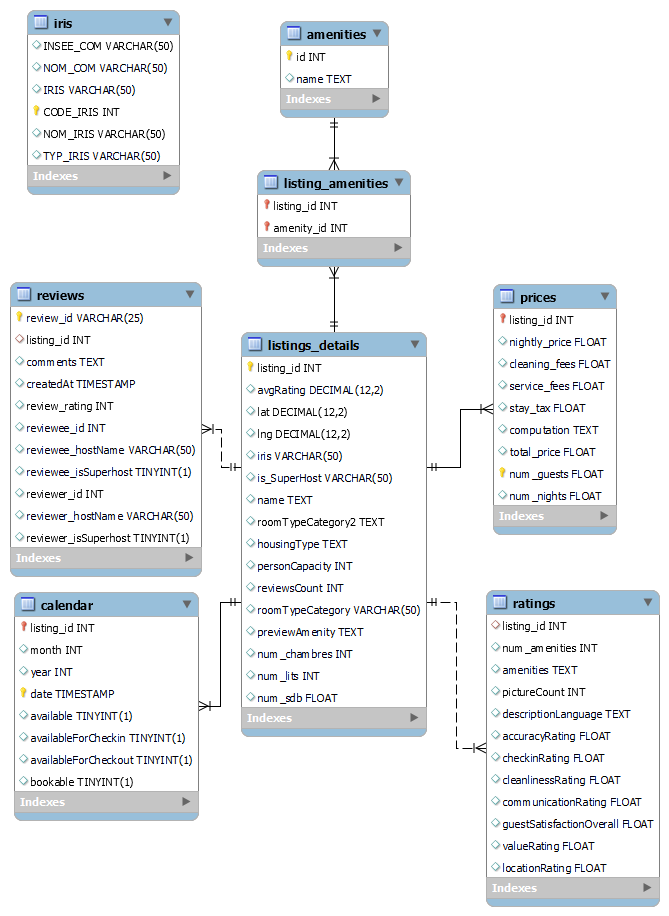

# Final comments

At this point the data is ready for exploratory analysis !